<a href="https://colab.research.google.com/github/fundaylncii/FeatureEngineering/blob/main/FeatureEngineeringAndDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics  import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


pd.set_option("display.max_columns", None)
pd.set_option("display.max_row",None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [4]:
df_ = pd.read_csv("/content/titanic.csv")
df = df_.copy()


In [5]:
def grap_col_names(dataframe, cat_th= 10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [6]:
def outlier_threshold (dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit , up_limit =  outlier_threshold(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_threshold(dataframe, col_name)
  dataframe.loc[dataframe[col_name] < low_limit, col_name] = low_limit
  dataframe.loc[dataframe[col_name] > up_limit, col_name] = up_limit



In [7]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [8]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [9]:
def rare_analyser(dataframe, target, cat_cols):
  for col in cat_cols:
    print(col, ":", len(dataframe[col].value_counts()))
    print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                        "RATIO": dataframe[col].value_counts() / len(dataframe),
                        "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end= "\n\n\n")



In [31]:
def rare_encoder(dataframe, rare_perc):
  temp_df = dataframe.copy()

  rare_columns = [col for col in temp_df.columns if temp_df[col].dtype == "O" and
                  (temp_df[col].value_counts()  / len(temp_df) < rare_perc).any(axis=None)]

  for var in rare_columns:
    tmp = temp_df[var].value_counts() / len(temp_df)
    rare_labels = tmp[tmp < rare_perc].index
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])

  return temp_df


In [35]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  return dataframe

In [10]:
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [11]:
## Değişken isimlerinin büyük harflere çevrilmesi

df.columns = [col.upper() for col in df.columns]
print(df.columns)

Index(['PASSENGERID', 'SURVIVED', 'PCLASS', 'NAME', 'SEX', 'AGE', 'SIBSP', 'PARCH', 'TICKET', 'FARE', 'CABIN', 'EMBARKED'], dtype='object')


In [12]:
## 1- FEATURE ENGINEERING (DEĞİŞKEN MUHENDİSLİĞİ)

df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype("int")
df.loc[((df["SIBSP"] + df["PARCH"]) > 0) , "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0) , "NEW_IS_ALONE"] = "YES"
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df["NEW_TITLE"] = df.NAME.str.extract(" ([A-Za-z]+)\.", expand=False)
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] > 21) & (df["AGE"] <= 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] > 21) & (df["AGE"] <= 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"
df.loc[(df["AGE"] <= 18), "NEW_AGE_CAT"] = "young"
df.loc[((df["AGE"] > 18) & (df["AGE"] < 56)), "NEW_AGE_CAT"] = "mature"
df.loc[ (df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"


In [13]:
print(df.shape)
df.head()

(891, 22)


,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_SEX_CAT,NEW_AGE_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,NO,23,4,0,Mr,66.000,2,maturemale,mature
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,NO,51,7,0,Mrs,38.000,2,maturefemale,mature
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,YES,22,3,0,Miss,78.000,1,maturefemale,mature
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,NO,44,7,0,Mrs,35.000,2,maturefemale,mature
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,YES,24,4,0,Mr,105.000,1,maturemale,mature


In [14]:
cat_cols, num_cols, cat_but_car = grap_col_names(df)
print(cat_cols)
print(num_cols)
print(cat_but_car)


Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8
['SEX', 'EMBARKED', 'NEW_IS_ALONE', 'NEW_TITLE', 'NEW_SEX_CAT', 'NEW_AGE_CAT', 'SURVIVED', 'PCLASS', 'SIBSP', 'PARCH', 'NEW_CABIN_BOOL', 'NEW_NAME_WORD_COUNT', 'NEW_NAME_DR', 'NEW_FAMILY_SIZE']
['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']
['NAME', 'TICKET', 'CABIN']


In [15]:
## SAYISAL DEĞİŞKENLER ÜZERİNDE ÖN İŞLEME:

num_cols = [col for col in num_cols if "PASSENGERID" not in col]
print(num_cols)

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']


In [16]:
## Aykırı değerlerin kontrol edilmesi:

for col in num_cols:
  print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [17]:
## Eşik değerler ile aykırı değerlerin değiştirilmesi:

for col in num_cols:
  replace_with_thresholds(df,col)

In [18]:
## Tekrar aykırı değer var mı diye kontrol edilir?
for col in num_cols:
  print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [19]:
## Eksik değerlerin kontrol edilmesi:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [20]:
## Cavin değişkeni yerine NEW_CABIN_BOOL değişkeni oluşturulduğu için cabin değişkeni drop edilir.
df.drop("CABIN", inplace=True, axis=1)

In [21]:
## Aynı zamand name ve ticket değişkenine de yeni değişkenler ürettiğimiz için gerek yoktur.bunlarda drop edilir.

remove_cols = ["TICKET","NAME"]
df.drop(remove_cols,inplace=True,axis=1)

In [22]:
## Tekrar eksik değerler kontrol edilir:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_SEX_CAT        177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [23]:
## Age değişkeni  NEW_TITLE değişkenine göre median aarak doldurulur
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [24]:
## yaşa bağlı oluşturduğumuz tüm yeni değişkenler yeniden oluşturulur.
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] > 21) & (df["AGE"] <= 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] > 21) & (df["AGE"] <= 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"
df.loc[(df["AGE"] <= 18), "NEW_AGE_CAT"] = "young"
df.loc[((df["AGE"] > 18) & (df["AGE"] < 56)), "NEW_AGE_CAT"] = "mature"
df.loc[ (df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

In [25]:
## tekrardan eksik değerler kontrol edilir:

missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


In [26]:
## Embark değerleri de mode değerleri ile doldurulur
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtypes == "O" and len(x.unique()) <= 10) else x, axis=0)



In [27]:
missing_values_table(df)

## eksik değer problemi çözümlendi.

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [28]:
## Label Encoding işlemi:

## iki sınıflı kategorik değişkenler dönüştürülür.

binary_cols = [ col for col in df.columns if df[col].dtype not in [int,float]
              and df[col].nunique() == 2]

print(binary_cols)

['SEX', 'NEW_IS_ALONE']


In [29]:
for col in binary_cols:
  df = label_encoder(df,col)

In [30]:
## Rare olabilecek değişkenlerin analizi:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_IS_ALONE : 2
              COUNT  RATIO  TARGET_MEAN
NEW_IS_ALONE                           
0               354  0.397        0.506
1               537  0.603        0.304


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.

In [32]:
## df rare encoder yapılır.
df = rare_encoder(df, 0.01)

In [33]:
df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

In [34]:
## One Hot Encodin işleminin yapılması:
## one_hot olacak değişkenlerin belirlenmesi:

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
print(ohe_cols)

['PCLASS', 'SIBSP', 'PARCH', 'EMBARKED', 'NEW_NAME_WORD_COUNT', 'NEW_TITLE', 'NEW_FAMILY_SIZE', 'NEW_SEX_CAT', 'NEW_AGE_CAT']


In [36]:
df = one_hot_encoder(df, ohe_cols)
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale,NEW_AGE_CAT_senior,NEW_AGE_CAT_young
0,1,0,1,22.000,7.250,0,0,23,0,66.000,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2,1,0,38.000,65.634,1,0,45,0,38.000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,1,22,0,78.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,0,44,0,35.000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,1,24,0,105.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [37]:
df.shape

(891, 52)

In [40]:
## yeni oluşan değişkenlerde rare analizi yapılması:

cat_cols, num_cols, cat_but_car = grap_col_names(df)

num_cosls = [ col for col in num_cols if "PASSENGERID" not in col]
print(num_cols)
print(cat_cols)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47
['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']
['SURVIVED', 'SEX', 'NEW_CABIN_BOOL', 'NEW_IS_ALONE', 'NEW_NAME_DR', 'PCLASS_2', 'PCLASS_3', 'SIBSP_1', 'SIBSP_2', 'SIBSP_3', 'SIBSP_4', 'SIBSP_5', 'SIBSP_8', 'PARCH_1', 'PARCH_2', 'PARCH_3', 'PARCH_4', 'PARCH_5', 'PARCH_6', 'EMBARKED_Q', 'EMBARKED_S', 'NEW_NAME_WORD_COUNT_4', 'NEW_NAME_WORD_COUNT_5', 'NEW_NAME_WORD_COUNT_6', 'NEW_NAME_WORD_COUNT_7', 'NEW_NAME_WORD_COUNT_8', 'NEW_NAME_WORD_COUNT_9', 'NEW_NAME_WORD_COUNT_14', 'NEW_TITLE_Miss', 'NEW_TITLE_Mr', 'NEW_TITLE_Mrs', 'NEW_TITLE_Rare', 'NEW_FAMILY_SIZE_2', 'NEW_FAMILY_SIZE_3', 'NEW_FAMILY_SIZE_4', 'NEW_FAMILY_SIZE_5', 'NEW_FAMILY_SIZE_6', 'NEW_FAMILY_SIZE_7', 'NEW_FAMILY_SIZE_8', 'NEW_FAMILY_SIZE_11', 'NEW_SEX_CAT_maturemale', 'NEW_SEX_CAT_seniorfemale', 'NEW_SEX_CAT_seniormale', 'NEW_SEX_CAT_youngfemale', 'NEW_SEX_CAT_youngmale', 'NEW_AGE_CAT_senior', 'NEW_AGE_CAT_young']


In [41]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000


SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


NEW_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
NEW_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667


NEW_IS_ALONE : 2
              COUNT  RATIO  TARGET_MEAN
NEW_IS_ALONE                           
0               354  0.397        0.506
1               537  0.603        0.304


NEW_NAME_DR : 2
             COUNT  RATIO  TARGET_MEAN
NEW_NAME_DR                           
0              881  0.989        0.383
1               10  0.011        0.500


PCLASS_2 : 2
          COUNT  RATIO  TARGET_MEAN
PCLASS_2                           
False       707  0.793        0.361
True        184  0.207        0.473


PCLASS

In [42]:
## kullanışsız sütunların belirlenmesi:
## bunlar silinebilir.

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
print(useless_cols)

['SIBSP_5', 'SIBSP_8', 'PARCH_3', 'PARCH_4', 'PARCH_5', 'PARCH_6', 'NEW_NAME_WORD_COUNT_9', 'NEW_NAME_WORD_COUNT_14', 'NEW_FAMILY_SIZE_8', 'NEW_FAMILY_SIZE_11']


In [45]:
## Standartlaştırma işlemi:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()


,PASSENGERID,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-1.730,-0.561,-0.821,-0.437,0.066
1,-1.726,0.663,2.032,2.248,-0.790
2,-1.722,-0.255,-0.788,-0.559,0.434
3,-1.718,0.434,1.419,2.126,-0.882
4,-1.715,0.434,-0.781,-0.315,1.260


In [55]:
## Model oluşturulması:
## bağımlı ve bağımsız değişkenler belirlenir.

y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state= 17)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)


0.8134328358208955

**Gemiye binecek kişilerin bilgileri önceden alınmış olsaydı ve bir tahminleme yapılacak olsaydı bu kişilerin %81 nin hayatta kalıp kalamayacağı doğru tahmin edilirdi.**

In [50]:
## Eğer df hiç önişlemeye tabi tutulmadan model oluşturulsaydı tahim oranı ??

dff = df_.copy()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
x = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state= 17)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7090909090909091

In [60]:
## üretilen değişkenleri değerlendirilmesi:

def plot_importance(model, feature, num=len(X), save= False):
  feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": feature.columns})
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                   ascending=False)[0:num])

  plt.title("Fature")
  plt.tight_layout()
  plt.show()
  if save:
    plt.savefig("importances.png")

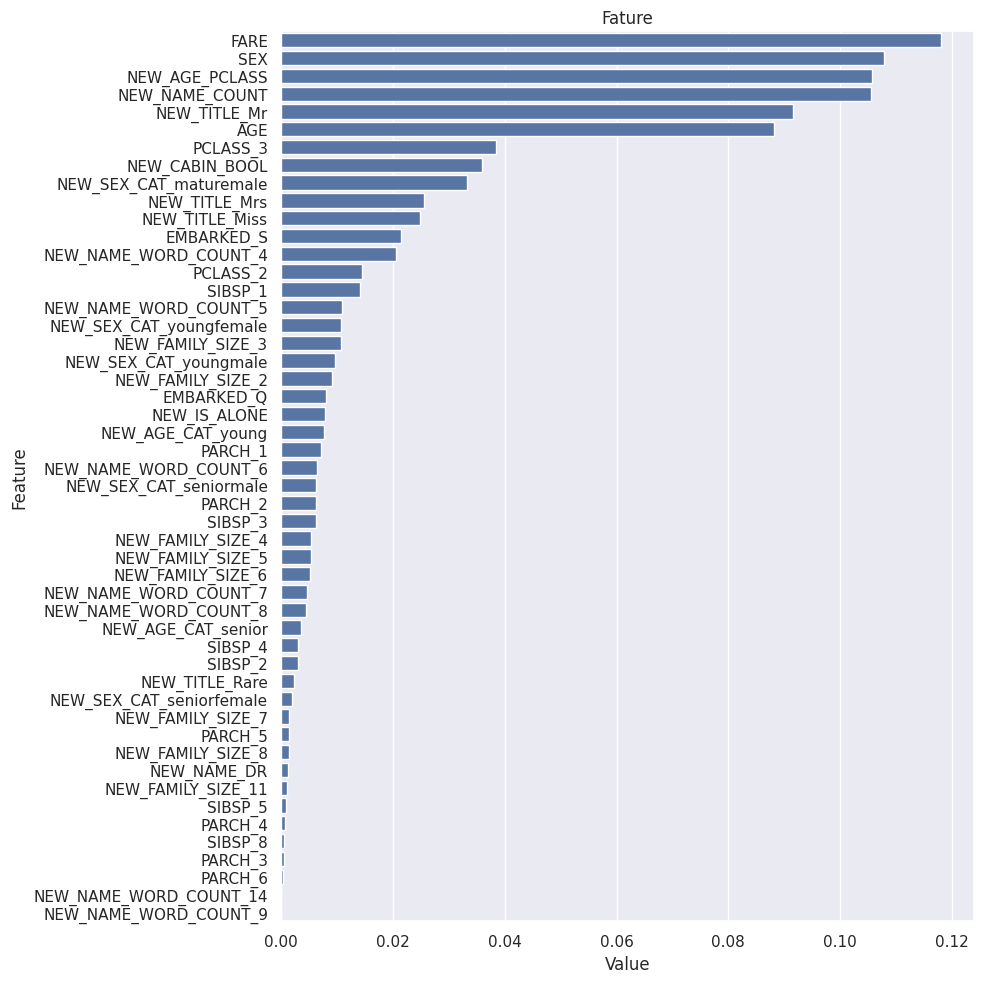

In [61]:
plot_importance(rf_model, X_train)